In [1]:
using Images, FileIO, ImageTransformations, ImageEdgeDetection, TestImages
using ImageEdgeDetection: Percentile
using Base.Threads
using Statistics
using FTPClient, IJulia
using ImageMorphology
using Graphs
using Plots
using Dierckx

In [2]:
Threads.nthreads()

8

In [ ]:
## Get image
function getNewestImage()
    ftp = FTP("ftp://pieter:ww@192.168.2.7:2211/DCIM/Camera")
    files = readdir(ftp)
    filename = last(filter(startswith("PXL_"), files))
    file = download(ftp,filename)
    close(ftp)
    img = load(file)
    return img
end

## STRUCTS
struct Bounds
    ytop :: Int64
    ybottom :: Int64
    xleft :: Int64
    xright :: Int64
end

struct Segment
    curve :: ParametricSpline
    kant :: Int
    corners :: Tuple{Tuple{Float64,Float64}, Tuple{Float64,Float64}}
    cornerspixel :: Tuple{CartesianIndex,CartesianIndex}
    # todo colors
end

struct Stukje
    randen :: Tuple{Segment, Segment, Segment, Segment}
    rawimg :: Matrix{RGB{N0f8}}
    rawimgbounds :: Bounds
end


##### FUNCTIONS FOR PROCESSING IMAGE
function getmask(img) 
    mask = zeros(size(img))

    hsv_img = HSV.(img)
    channels = channelview(float.(hsv_img))
    saturation = channels[2,:,:]
    value = channels[3,:,:]
    saturation[value .<0.1] .= 0

    mask[saturation+value*2 .- 0.5 .> 0.7] .= 1
    step1 = imfill(Bool.(mask), 0:1000)
    step2 = .!(step1)
    mask = .!(imfill(step2, 0:1000))
    return mask
end

function makeborder(mask)
    return border = dilate(.!(mask)) .& mask
end

function toCartesian(img, index)
    width = size(img)[1]
    return CartesianIndex(mod(index-1, width)+1, div(index-1, width)+1)
end

function thinborder(border)
    edges = [ (p.first, qx ) 
                for p=pairs(border), diff=[CartesianIndex(0,1), CartesianIndex(1,0)] 
                for qx=[p.first + diff] 
                if p.second == 1 && border[qx] == 1]
    linearindices = LinearIndices(border)
    edgeslinind = map( tup -> Edge(linearindices[tup[1]], linearindices[tup[2]]), edges)

    g = SimpleGraphFromIterator(edgeslinind)
    v = first(filter( v -> degree(g,v) == 2, vertices(g)))
    n = neighbors(g,v)[1]
    rem_edge!(g,Edge(v,n))

    shortestpath = a_star(g, v, n)
    cycle = map(src, shortestpath)
    push!(cycle, n)

    cyclecoord = map(x -> toCartesian(border,x), cycle)
    bordernew = zeros(size(border))
    bordernew[cyclecoord] .= 1
    return (cyclecoord,bordernew)
end

function thinborderupdatemask(border, mask)
    (bordercoords, tborder) = thinborder(border)
    mask = mask .- (border .- tborder)
    return (bordercoords, tborder, mask)
end

function getcorners(bordercoords, border, mask)
    tmpmask = copy(mask)
    kr = 5 # 30
    krm = 5 # 1
    @threads for c in bordercoords
        som = 0
        i = 0
        for dc = [ CartesianIndex(krm*dx,krm*dy) for dx=-kr:kr, dy=-kr:kr ]
            som += mask[c+dc]
            i += 1
        end
        avg = som/i
        tmpmask[c] = avg
    end

    bordercopy = copy(bordercoords)

    corners = Vector{CartesianIndex{2}}(undef, 4)
    for i in 1:4
        m = partialsort(bordercopy, by=(c -> Gray(tmpmask[c])), 1)
        corners[i] = m
        m = Tuple(m)
        filter!(c -> abs(Tuple(c)[1] - m[1]) + abs(Tuple(c)[2] - m[2]) > 150, bordercopy)
    end

    tl = argmin(c -> Tuple(c)[1] + Tuple(c)[2], corners)
    bl = argmin(c -> -Tuple(c)[1] + Tuple(c)[2], corners)
    tr = argmin(c -> Tuple(c)[1] - Tuple(c)[2], corners)
    br = argmin(c -> -Tuple(c)[1] - Tuple(c)[2], corners)

    return ((tl,bl,tr,br))
end


function makenormalizedpoints((tl,bl,tr,br), bordercoords) #, img) :: Vector{Point}
    scale = maximum(Tuple(br - tl))
    function f(c)
        (y,x) = Tuple(c .- tl)
        return (x/scale, y/scale) #Point(x/scale, y/scale, img[c])
    end
    scaled = map(f, bordercoords)
    tln = f(tl)
    bln = f(bl)
    trn = f(tr)
    brn = f(br)
    return ((tln,bln,trn,brn), scaled)
end

function getSegments((tl,bl,tr,br), bordercoords)
    corners = (tl,bl,tr,br)
    initspul = Iterators.takewhile( e -> !(e in corners), bordercoords)
    restspul = Iterators.dropwhile( e -> !(e in corners), bordercoords)
    bordercoords = Iterators.flatten((restspul, initspul))
    
    segs = Vector(undef, 4)
    for i in 1:4
        (head, tail) = Iterators.peel(bordercoords)
        segs[i] = Iterators.flatten(([head], Iterators.takewhile( e -> !(e in corners), tail)))
        bordercoords = Iterators.dropwhile( e -> !(e in corners), tail)
    end

    function tlfirst(segs)
        eerstedeel = collect(Iterators.takewhile(l -> first(l) != tl, segs))
        restdeel = collect(Iterators.dropwhile(l -> first(l) != tl, segs))
        return append!(restdeel, eerstedeel)
    end

    segs = tlfirst(segs)
    if first(segs[2]) != tr
        reverse!(segs)
        map(reverse!, segs)
        segs = tlfirst(segs)
    end

    segs = map(collect, segs)

    push!(segs[1], tr)
    push!(segs[2], br)
    push!(segs[3], bl)
    push!(segs[4], tl)

    return segs
end

function makeFittedSegments(cornerspix,cornersnorm,segments) :: Tuple{Segment, Segment, Segment, Segment}
    segs = Vector(undef, 4)
    kant = 1
    for (i,j) in [(1,3),(3,4),(4,2),(2,1)]
        corners = (cornersnorm[i], cornersnorm[j])
        cornersp = (cornerspix[i], cornerspix[j])

        seg = segments[kant]
        xyvals = stack((getindex.(seg,1), getindex.(seg,2)), dims=1)
        spline = ParametricSpline(xyvals; s=0.001) #s=0.0006
        
        segs[kant] = Segment(spline, kant, corners, cornersp)

        kant += 1
    end
    
    segs = Tuple(segs)
    return segs
end


getNewestImage (generic function with 1 method)

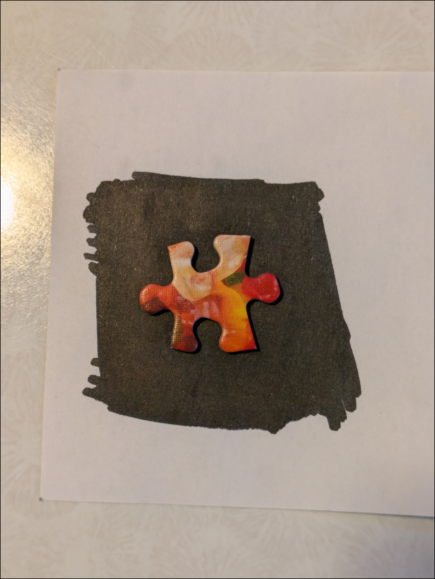

(4624, 3472)

In [5]:
#rawimg = getNewestImage()
rawimg = load("PXL_20241123_150705922.jpg")
display(rawimg)
size(rawimg)

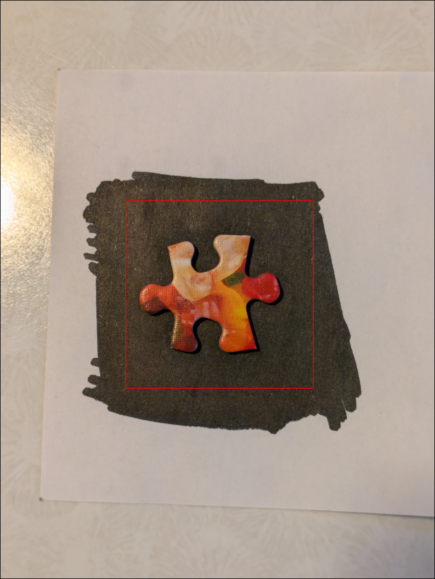

In [6]:
xleft = 1000
ytop = 1600
width = 1500
height = 1500

xright = xleft + width
ybottom = ytop + height
borderthickness = 5
img = RGB.(rawimg)
img[ytop:ybottom, [xleft:(xleft+borderthickness); xright:(xright+borderthickness)]] .= RGB(1,0,0)
img[[ytop:(ytop+borderthickness); ybottom:(ybottom+borderthickness)], xleft:xright] .= RGB(1,0,0)
img

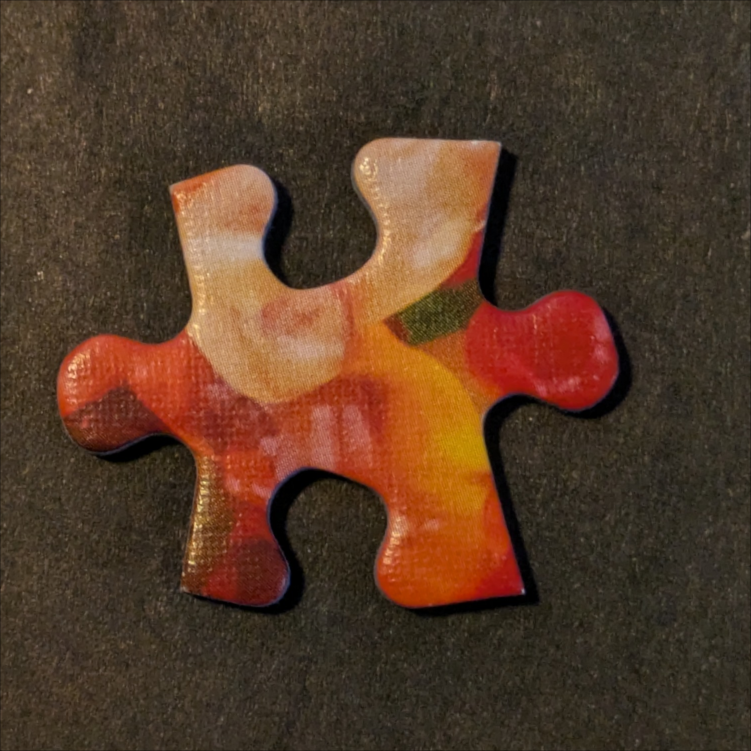

In [ ]:

bounds = Bounds(ytop, ybottom, xleft, xright)
img = rawimg[ytop:ybottom, xleft:xright]

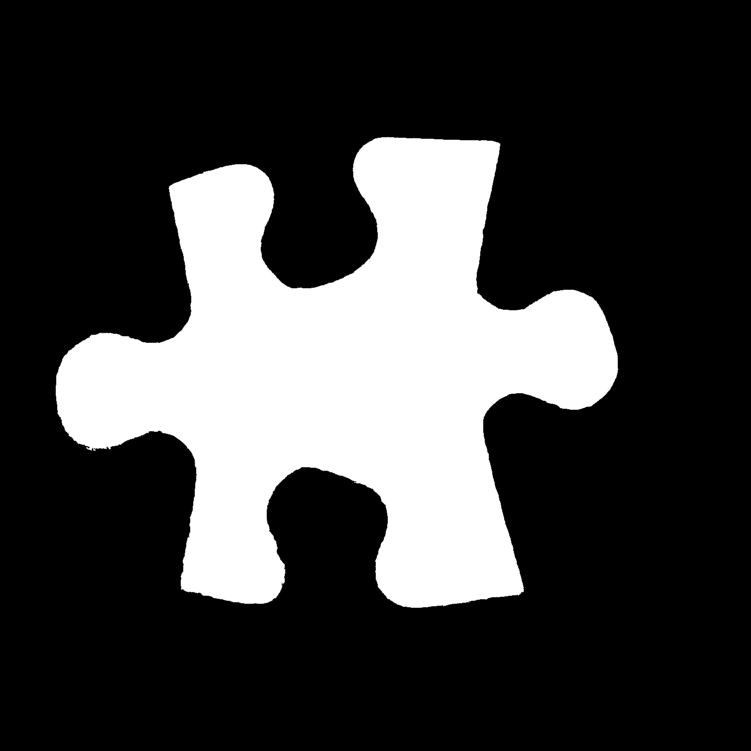

In [ ]:


mask = getmask(img)
Gray.(mask)
#Gray.(value+saturation*2 .-0.5)


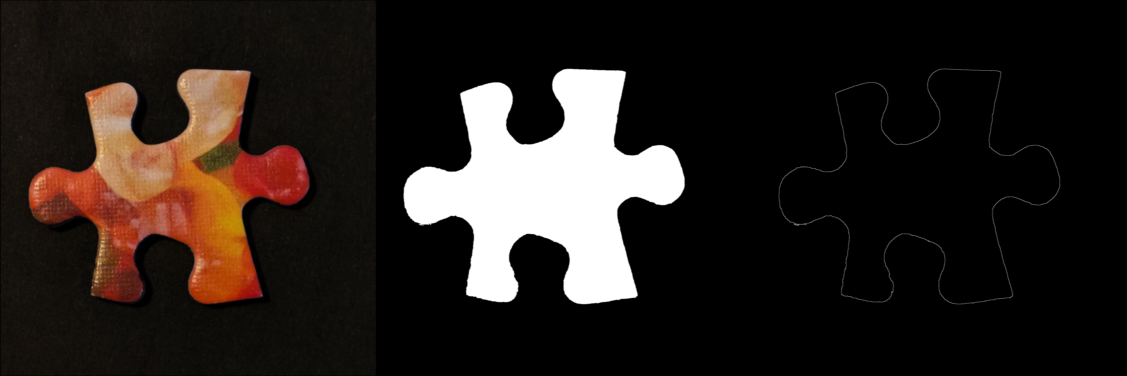

In [ ]:


border = makeborder(mask)

mosaicview(img .* (mask .* 0.7 .+ 0.3), Gray.(mask), Gray.(border), nrow=1)

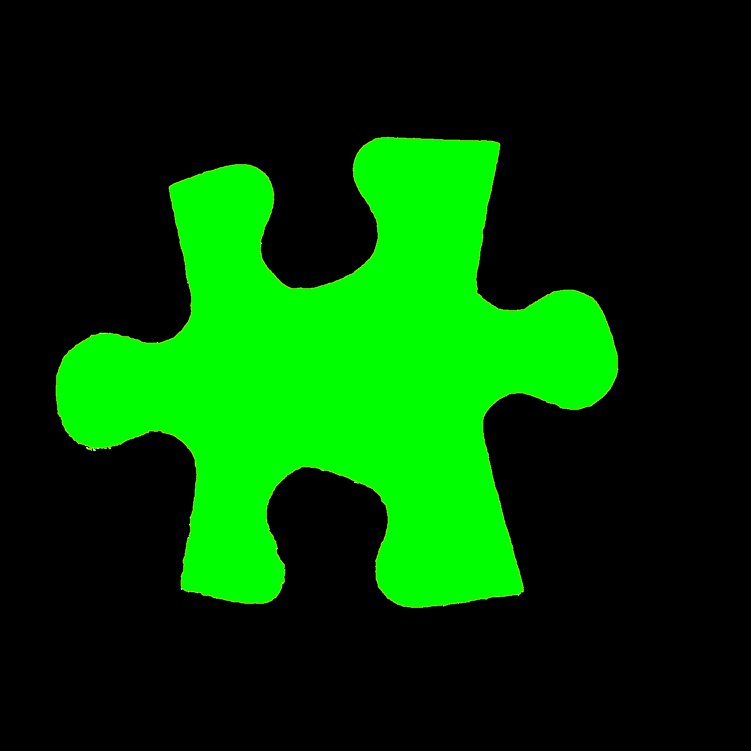

In [ ]:


(bordercoords, tborder, tmask) = thinborderupdatemask(border, mask)

RGB.(border .- tborder) + tborder .* RGB(1,0,0) + mask .* RGB(0,1,0)
#Gray.(mask)




In [21]:
# using ImageClipboard
# #RGB.(RGB.(border .- tborder) + tborder .* RGB(1,0,0) + mask .* RGB(0,1,0))
# clipboard_img(map(clamp01nan, RGB.(RGB.(border .- tborder) + tborder .* RGB(1,0,0) + mask .* RGB(0,1,0))))

(CartesianIndex(374, 339), CartesianIndex(1178, 364), CartesianIndex(288, 1000), CartesianIndex(1182, 1047))


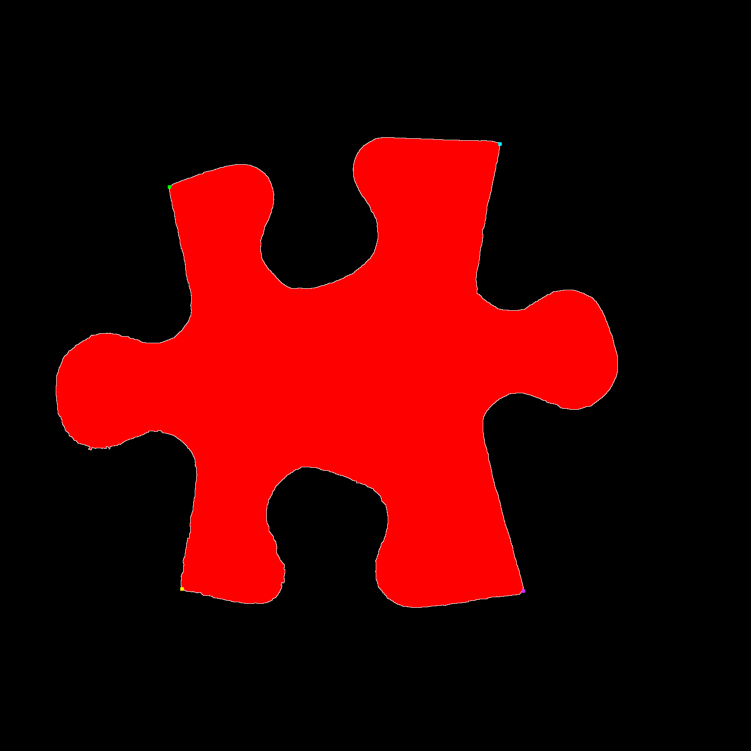

In [23]:
(tl,bl,tr,br) = getcorners(bordercoords, tborder, tmask)

# maximizers = partialsort(bordercoords, by=(c -> Gray(asdf[c])), 1:4)
# println(maximizers)
# println(Gray.(asdf[maximizers]))
println((tl,bl,tr,br))

tlblob = [ tl+CartesianIndex(x,y) for x=-3:3, y=-3:3]
blblob = [ bl+CartesianIndex(x,y) for x=-3:3, y=-3:3]
trblob = [ tr+CartesianIndex(x,y) for x=-3:3, y=-3:3]
brblob = [ br+CartesianIndex(x,y) for x=-3:3, y=-3:3]

asdf = tmask .* RGB(1,0,0)
asdf[bordercoords] .= RGB(1,1,1)

asdf[tlblob] .= RGB(0,1,0) # groen
asdf[blblob] .= RGB(1,1,0) # geel
asdf[trblob] .= RGB(0,1,1) # felblauw
asdf[brblob] .= RGB(0.8,0.2,1) # roze
asdf

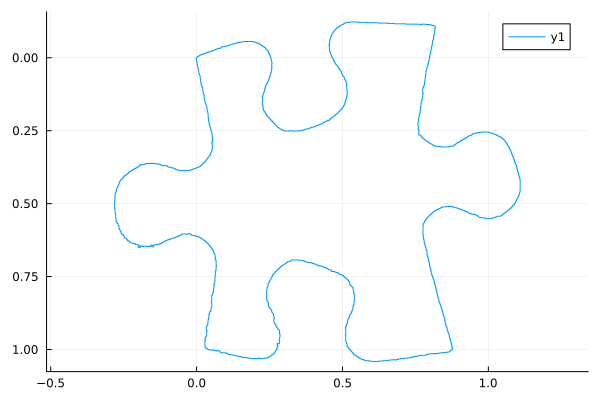

In [ ]:
#display(plot(map( tup -> (tup[2], 1500-tup[1]), Tuple.(bordercoords)) , aspect_ratio=:equal))

#struct Point
#    x :: Float64
#    y :: Float64
#    color :: RGB{N0f8}
#end
#function pcoords(point :: Point) :: Tuple{Float64, Float64}
#    return (point.x, point.y)
#end
#function pcolor(point:: Point) :: RGB{N0f8}
#    return point.color
#end
## TODO KLEUREN 


((tln,bln,trn,brn), bordercoordsn) = makenormalizedpoints((tl,bl,tr,br), bordercoords)

plot(bordercoordsn, aspect_ratio=:equal, yflip=true)


((0.0, 0.0), (0.03094059405940594, 0.995049504950495), (0.818069306930693, -0.10643564356435643), (0.8762376237623762, 1.0))


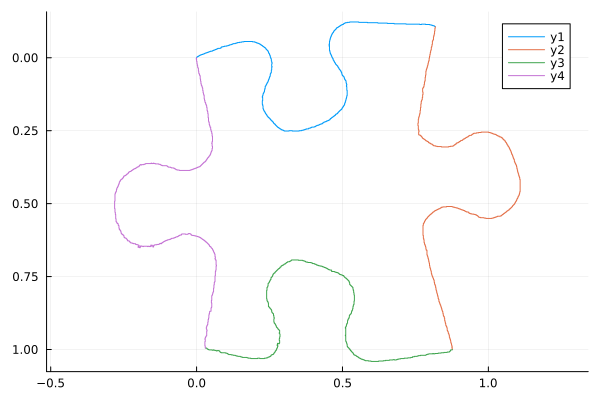

In [ ]:

println((tln,bln,trn,brn))
segments = getSegments((tln,bln,trn,brn), bordercoordsn)


plot(segments[1], aspect_ratio=:equal, yflip=true)
plot!(segments[2])
plot!(segments[3])
plot!(segments[4])

In [ ]:


x = makeFittedSegments((tl,bl,tr,br),(tln,bln,trn,brn),segments)
display(x)


spline = x[1].curve


tvals = range(0.0, 1.0, 10000)
output = spline(tvals)
outputx = output[1, :]
outputy = output[2, :]
plot(segments[1])
plot!(outputx, outputy, aspect_ratio=:equal, yflip=true)



UndefVarError: UndefVarError: `tl` not defined in `Main`
Suggestion: check for spelling errors or missing imports.